In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb



In [2]:
df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")

C:\Users\Woj-tek\AppData\Local\Temp\ipykernel_91576\713402779.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")


In [3]:
# z kolumny 'Event.Date' wyciągamy do osobnych kolumn rok, miesiąc i dzień
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# z kolumny 'Location' wyciągamy do osbnych kolumn miasto i stan
df['City'] = df['Location'].str.split(',').str[0]
df['State'] = df['Location'].str.split(',').str[1]

# 'Unk' i 'UNK' zamieniamy na jedną wartość 'Unknown'
df['Weather.Condition'].replace(to_replace = ['Unk', 'UNK'], value = 'Unknown', inplace = True)

# wartości np. Fatal(1), Fatal(123) zamieniamy na jedną wartość 'Fatal'
df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')

# puste wartości uzupełniamy najczęściej występującymi wartościami w danej kolumnie
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna(df['Purpose.of.flight'].mode()[0])
df['Weather.Condition'] = df['Weather.Condition'].fillna(df['Weather.Condition'].mode()[0])
df['Engine.Type'] = df['Engine.Type'].fillna(df['Engine.Type'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])

# w kolumnie number.of.Engines średnia oraz mediana jest podabna, wiec uzupełniam puste wartosci medianą
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

C:\Users\Woj-tek\AppData\Local\Temp\ipykernel_91576\850482051.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')


In [4]:
# poniższy kod zamienia wszystkie wartości NaN na 'Unavailable' albo 'Unknown' dla kolumn gdzie już takie wartości występują. 
# Dzięki temu po późniejszym zastosowaniu df.dropna() zamiast 50k rekordów zostaje aż 77k. 
# Pytanie tylko czy wartości 'Unknown' w modelu mają jakikolwiek sens i czy nie lepiej faktycznie zredukować dane do tych 50k.
'''
df['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')
df['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')
df['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')
df['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')
df['Make'] = df['Make'].fillna('Unknown')
'''

"\ndf['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')\ndf['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')\ndf['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')\ndf['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')\ndf['Make'] = df['Make'].fillna('Unknown')\n"

In [5]:
df = df.dropna()

zamiana nazw miesięcy na numery miesięcy

In [6]:
Month = {'October':10, 'July': 7, 'August':8, 'June':6, 'January':1, 'February':2,
       'March':3, 'April':4, 'May':5, 'September':9, 'November':11, 'December':12}

In [7]:
df['Month'] = df['Month'].replace(Month)

In [8]:
df.Month.unique()

array([10,  7,  8,  6,  1,  2,  3,  4,  5,  9, 11, 12], dtype=int64)

In [9]:
df.rename(columns={'Total.Fatal.Injuries': 'TFI'}, inplace=True)

wyrzucam:
engine type następnie Purpose of flight następnie number of engines

In [10]:
df = df[['TFI', 'Weather.Condition', 'Broad.phase.of.flight','Month']]

In [11]:
df['TFI'] = df['TFI'].where(df['TFI'] == 0, 1)

In [12]:
df.TFI.value_counts()

0.0    38128
1.0    11370
Name: TFI, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49498 entries, 0 to 63909
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TFI                    49498 non-null  float64
 1   Weather.Condition      49498 non-null  object 
 2   Broad.phase.of.flight  49498 non-null  object 
 3   Month                  49498 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.9+ MB


In [14]:
df.groupby('Broad.phase.of.flight')['TFI'].agg(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
Broad.phase.of.flight,,,,,
Approach,5415,0.0,1.0,0.292521,1584.0
Climb,1649,0.0,1.0,0.367495,606.0
Cruise,8391,0.0,1.0,0.323918,2718.0
Descent,1454,0.0,1.0,0.308803,449.0
Go-around,1116,0.0,1.0,0.238351,266.0
Landing,11614,0.0,1.0,0.024625,286.0
Maneuvering,7104,0.0,1.0,0.443412,3150.0
Other,96,0.0,1.0,0.458333,44.0
Standing,553,0.0,1.0,0.106691,59.0


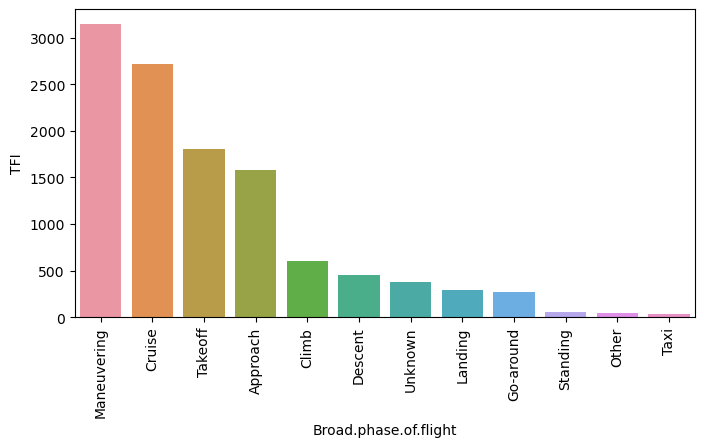

In [15]:
phase_flight_grouped= df.groupby("Broad.phase.of.flight").sum('TFI').reset_index().sort_values(by='TFI',ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data = phase_flight_grouped, x = phase_flight_grouped['Broad.phase.of.flight'],y= phase_flight_grouped['TFI'], estimator = sum)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8,4))
df['State'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("State", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 States", size=20)
plt.show()

plt.figure(figsize=(8,4))
df['Make'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("Make", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 Plane Makes", size=20)
plt.show()

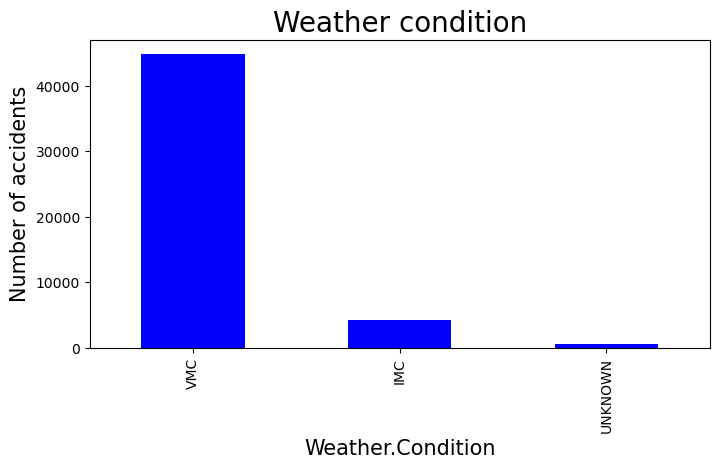

In [16]:
plt.figure(figsize=(8,4))
df['Weather.Condition'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xlabel("Weather.Condition", size=15)
plt.ylabel("Number of accidents", size=15)
plt.title("Weather condition", size=20)
plt.show()

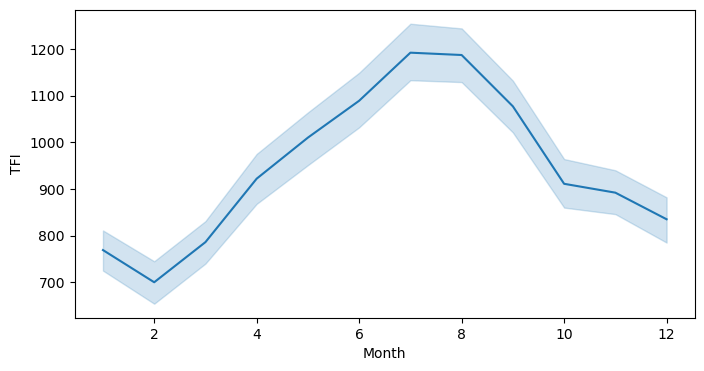

In [17]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = df, x = df['Month'], y= df['TFI'],estimator=sum)
plt.show()

<AxesSubplot:xlabel='Weather.Condition', ylabel='TFI'>

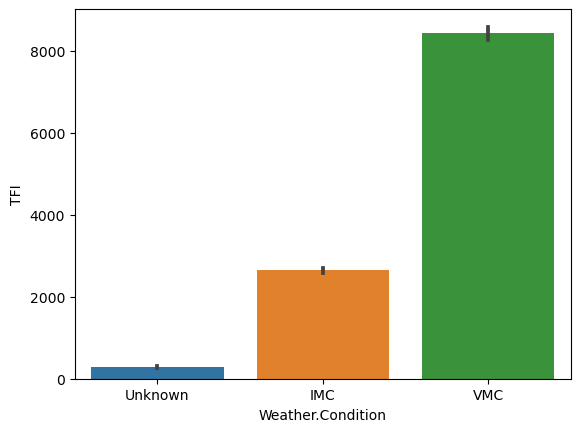

In [18]:
sns.barplot(data=df,x='Weather.Condition',y='TFI',estimator=sum)

In [19]:
#sns.barplot(data = df,x=df['Purpose.of.flight'],y=df['TFI'],estimator=sum)
#plt.xticks(rotation=90);

In [20]:
df.describe()

,TFI,Month
count,49498.000000,49498.000000
mean,0.229706,6.590489
std,0.420648,3.057765
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,7.000000
75%,0.000000,9.000000
max,1.000000,12.000000


In [21]:
df = df.reset_index()

___

In [22]:
df_X = df[['TFI', 'Weather.Condition', 'Broad.phase.of.flight','Month']]

In [23]:
lista_kolumn_X = list(df_X.columns)

for i in lista_kolumn_X:
    print(i, df_X[i].value_counts().count())

TFI 2
Weather.Condition 3
Broad.phase.of.flight 12
Month 12


In [24]:
df_X_get_dummies = pd.get_dummies(df_X)

In [25]:
df_X_get_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49498 entries, 0 to 49497
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TFI                                49498 non-null  float64
 1   Month                              49498 non-null  int64  
 2   Weather.Condition_IMC              49498 non-null  uint8  
 3   Weather.Condition_Unknown          49498 non-null  uint8  
 4   Weather.Condition_VMC              49498 non-null  uint8  
 5   Broad.phase.of.flight_Approach     49498 non-null  uint8  
 6   Broad.phase.of.flight_Climb        49498 non-null  uint8  
 7   Broad.phase.of.flight_Cruise       49498 non-null  uint8  
 8   Broad.phase.of.flight_Descent      49498 non-null  uint8  
 9   Broad.phase.of.flight_Go-around    49498 non-null  uint8  
 10  Broad.phase.of.flight_Landing      49498 non-null  uint8  
 11  Broad.phase.of.flight_Maneuvering  49498 non-null  uin

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
# Utworzenie obiektu klasy StandardScaler 
#scaler = StandardScaler()

In [28]:
#scaler.fit(X_train)

In [29]:
#[scaler.mean_, scaler.var_]

In [30]:
import xgboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree


In [31]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plot

In [32]:
#xgb_reg.fit(X_train, y_train)

In [33]:
#y_pred = xgb_reg.predict(X_test)

In [34]:
xgb_clf = XGBClassifier(max_depth = 3, n_estimators=150, subsample = 0.75)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df_X_get_dummies['TFI'], test_size=0.3,random_state=123)

In [36]:
print(X_train.shape) #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_s
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34648, 17)
(14850, 17)
(34648,)
(14850,)


In [37]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
y_predict = xgb_clf.predict(X_test)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [40]:
pred_train = xgb_clf.predict(X_train)
pred_test = xgb_clf.predict(X_test)

In [41]:
confusion_matrix(y_test, y_predict)

array([[11499,     0],
       [    0,  3351]], dtype=int64)

In [42]:
confusion_matrix(y_train,pred_train)

array([[26629,     0],
       [    0,  8019]], dtype=int64)

In [43]:
print(classification_report(y_train,pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26629
         1.0       1.00      1.00      1.00      8019

    accuracy                           1.00     34648
   macro avg       1.00      1.00      1.00     34648
weighted avg       1.00      1.00      1.00     34648



In [44]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11499
         1.0       1.00      1.00      1.00      3351

    accuracy                           1.00     14850
   macro avg       1.00      1.00      1.00     14850
weighted avg       1.00      1.00      1.00     14850

